# 南京大学物联网技术导论课程Project(2021秋学期)
课题：基于智能手机感知的新型认证技术研究

主题：基于手机加速度传感器的步态识别认证方法

Author: 任隽阳 MG21330046

## 导入必要的库和初始化

In [ ]:
import csv
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
import thinkdsp

config = {
    "font.family": 'Times New Roman',  # 设置字体类型
    "font.size": 30,
    # "mathtext.fontset":'stix',
}
rcParams.update(config)

## 函数定义部分
###  从原始csv中读入加速度传感器的数据，并初始化相关字段

In [ ]:
def getRawData(datapath):
    rawData = []
    cnt = 0
    with open(datapath+'/Accelerometer.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            nowRawData = {}
            nowRawData["time"] = int(float(row["seconds_elapsed"])*100)/100
            nowRawData["a"] = math.sqrt(
                float(row["x"])**2+float(row["y"])**2+float(row["z"])**2)
            nowRawData["rawIndex"] = cnt
            nowRawData["isPeak"] = False
            rawData.append(nowRawData)
            cnt += 1
    return rawData

### 滤波器滤除高频噪声
因为实际采样频率为$100Hz$，实际运行中未采用该函数

In [ ]:
def filterData(rawData):
    wn = 2*40/100
    b, a = signal.butter(8, wn, 'lowpass')  # 配置滤波器 8 表示滤波器的阶数
    filtedData = signal.filtfilt(b, a, [i["a"] for i in rawData])
    for i in range(len(filtedData)):
        rawData[i]["filted_a"] = filtedData[i]

### 窗口平均法平滑
平滑后丢失较多细节，实际运行中未采用该函数

In [ ]:
def avgSmooth(rawData, windowSize=5):
    ys = [i["a"] for i in rawData]
    window = np.ones(windowSize)
    window /= sum(window)
    N = len(ys)
    smoothed = np.zeros(N)
    padded = thinkdsp.zero_pad(window, N)
    rolled = padded

    for i in range(N):
        smoothed[i] = sum(rolled * ys)
        rolled = np.roll(rolled, 1)
    for i in range(len(smoothed)):
        rawData[i]["smoothed_a"] = smoothed[i]
    # return smoothed

### 将指定时间段的加速度值绘制折线图

In [ ]:
def printData(rawData, stTime, endTime, filt=False, smoot=False):
    # plt.figure(figsize=(16,9),dpi = 100)
    timeAxis = []
    accAxis = []
    if filt:
        filterData(rawData)
        faccAxis = []
    if smoot:
        avgSmooth(rawData)
        smooAxis = []
    for eachData in rawData:
        if eachData["time"] < stTime:
            continue
        elif eachData["time"] > endTime:
            break
        else:
            timeAxis.append(eachData["time"])
            accAxis.append(eachData["a"])
            if filt:
                faccAxis.append(eachData["filted_a"])
            if smoot:
                smooAxis.append(eachData["smoothed_a"])
    plt.plot(timeAxis, accAxis, marker='o')
    if filt:
        plt.plot(timeAxis, faccAxis, marker='.', linestyle=':')
    if smoot:
        plt.plot(timeAxis, smooAxis, marker='*', linestyle=':')
    # plt.show()

### 获取FTT频谱
实际运行未观察到频率有集中分布

In [ ]:
def getRawFttFigure(rawData, fs=100):
    # plt.figure(figsize=(16,9),dpi = 100)
    y = [i["a"] for i in rawData]
    N = len(y)  # 采样点数
    # fs=100# 采样频率
    df = fs/(N-1)  # 分辨率
    f = [df*n for n in range(0, N)]  # 构建频率数组
    Y = np.fft.fft(y)*2/N  # *2/N 反映了FFT变换的结果与实际信号幅值之间的关系
    absY = [np.abs(x) for x in Y]  # 求傅里叶变换结果的模

    plt.plot(f, absY)
    # plt.xlabel('freq(Hz)')
    # plt.title("fft")
    # plt.show()

### 找到数据中的极值点

In [ ]:
def extreRecog(rawData):
    rawData[0]["upCnt"] = 0
    rawData[0]["upSum"] = 0
    candidateData = []
    for i in range(1, len(rawData)):
        if rawData[i]["a"] >= rawData[i-1]["a"]:
            rawData[i]["upCnt"] = rawData[i-1]["upCnt"]+1
            rawData[i]["upSum"] = rawData[i-1]["upSum"] + \
                rawData[i]["a"]-rawData[i-1]["a"]
            rawData[i-1]["isExtre"] = False
        else:
            rawData[i]["upCnt"] = 0
            rawData[i]["upSum"] = 0
            if rawData[i-1]["upCnt"] != 0 and rawData[i-1]["upSum"] != 0:
                rawData[i-1]["isExtre"] = True
                candidateData.append(rawData[i-1])
            else:
                rawData[i-1]["isExtre"] = False
    if rawData[-1]["a"] >= rawData[-2]["a"]:
        rawData[-1]["isExtre"] = True
        candidateData.append(rawData[-1])
    else:
        rawData[-1]["isExtre"] = False
    return candidateData

### 反复寻找极值点，得到一个周期的峰值

In [ ]:
def eliminateCandidate(candidateData):
    totalTime = len(candidateData)/100
    # plt.figure(figsize=(16,9),dpi = 100)
    # printData(candidateData,60,80)
    while len(candidateData) > (2.5*totalTime):
        candidateData = extreRecog(candidateData)
    # printData(candidateData,60,80)
    # plt.show()
    # print(len(candidateData))
    # print(candidateData)
    candidateIndexList = []
    for candidate in candidateData:
        candidateIndexList.append(candidate["rawIndex"])
    return candidateIndexList


def labelPeak(rawData):
    candidateIndexList = eliminateCandidate(rawData)
    # print(candidateIndexList)
    # print(rawData[candidateIndexList[0]])
    extreRecog(rawData)  # reserve raw extre data
    # print(rawData[candidateIndexList[0]])
    for eachIndex in candidateIndexList:
        rawData[eachIndex]["isPeak"] = True
    return candidateIndexList

### 一个通过复合指标寻找周期内峰值的尝试
指标为：极大值点本身加速度值*2+极值大点与前一个相邻的极小值点的差+极值大点与前一个相邻的极小值点的差之间的采样点数目/2

绘制直方图，发现不同窗口不同，无法全局来做

该方法未采用

In [ ]:
def getPeakIndicator(extreData, stTime, endTime):
    plt.figure(figsize=(16, 9), dpi=100)
    timeAxis = []
    accAxis = []
    upSumAxis = []
    indicatorAxis = []

    for eachData in extreData:
        if eachData["time"] < stTime:
            continue
        elif eachData["time"] > endTime:
            break
        else:
            timeAxis.append(eachData["time"])
            accAxis.append(eachData["a"])
            upSumAxis.append(eachData["upSum"])
            indicatorAxis.append(
                eachData["a"]*2+eachData["upSum"]+eachData["upCnt"])

    plt.plot(timeAxis, accAxis, marker='o')
    # plt.plot(timeAxis, upSumAxis,marker='*')
    plt.plot(timeAxis, indicatorAxis, marker='.')
    plt.show()
    return indicatorAxis


def getAllPeakInfo(rawData, wantedObj="isPeak"):
    extreRecog(rawData)
    extreDataList = []
    for eachData in rawData:
        extreData = {}
        if eachData[wantedObj]:
            extreData["time"] = eachData["time"]
            extreData["a"] = eachData["a"]
            extreData["upSum"] = eachData["upSum"]
            extreData["upCnt"] = eachData["upCnt"]
            extreDataList.append(extreData)
    return extreDataList


def getHistofList(indiList):
    group = [i for i in range(int(max(indiList)))]
    plt.figure(figsize=(16, 9), dpi=100)
    plt.hist(indiList, group, histtype='bar', rwidth=0.8)
    plt.show()

### 剔除部分间隔较小的点

In [ ]:
def delIncorrectPeak(rawData, totalTime):
    peakIndex = labelPeak(rawData)

    if len(peakIndex) < totalTime*1.1 and len(peakIndex) > totalTime*0.9:
        return peakIndex  # 观测经验：一秒一周期。如对应较好，可不必剔除
    intervalTimeList = []
    # print(len(peakIndex))
    # print(totalTime)
    for i in range(1, len(peakIndex)):
        intervalTimeList.append(
            rawData[peakIndex[i]]["time"]-rawData[peakIndex[i-1]]["time"])
    # print(intervalTimeList)
    # plt.figure(figsize=(16,9),dpi = 100)
    # plt.hist(intervalTimeList, 20, histtype='bar', rwidth=0.8)
    # plt.show()
    sumThreshold = np.mean(intervalTimeList)  # *0.8
    for i in range(1, len(peakIndex)-1):
        if (intervalTimeList[i-1] < sumThreshold) and (intervalTimeList[i] < sumThreshold):
            rawData[peakIndex[i]]["isPeak"] = False

    peakIndex = []
    for eachData in rawData:
        if eachData["isPeak"]:
            peakIndex.append(eachData["rawIndex"])
    return peakIndex
    # intervalTimeList=[]
    # print(len(peakIndex))
    # for i in range(1,len(peakIndex)):
    #     intervalTimeList.append(rawData[peakIndex[i]]["time"]-rawData[peakIndex[i-1]]["time"])
    # print(intervalTimeList)


### 切割出每一周期的信号

In [ ]:
def splitSteps(rawData, plotOpt=True):
    peakIndex = delIncorrectPeak(rawData, len(rawData)/100)[7:-7]
    rawStepCycleList = []
    if plotOpt:
        plt.figure(figsize=(16, 9), dpi=100)
    for i in range(1, len(peakIndex)):
        thisCyclea = []
        thisCyclet = []
        for j in range(peakIndex[i-1], peakIndex[i]+1):
            thisCyclea.append(rawData[j]["a"])
            thisCyclet.append(rawData[j]["time"])
        if i > 4 and i < 13 and plotOpt:
            plt.plot(thisCyclet, thisCyclea)
        rawStepCycleList.append(thisCyclea)
    if plotOpt:
        plt.show()
    return rawStepCycleList

## 主程序由此开始
先读取数据

In [ ]:
rjyData = getRawData("rjy_step")
ljmData = getRawData("ljm_step")
plt.figure(figsize=(16, 9), dpi=100)
printData(rjyData, 65, 67)
printData(ljmData, 65, 67)
plt.show()

### 频谱图无明显规律

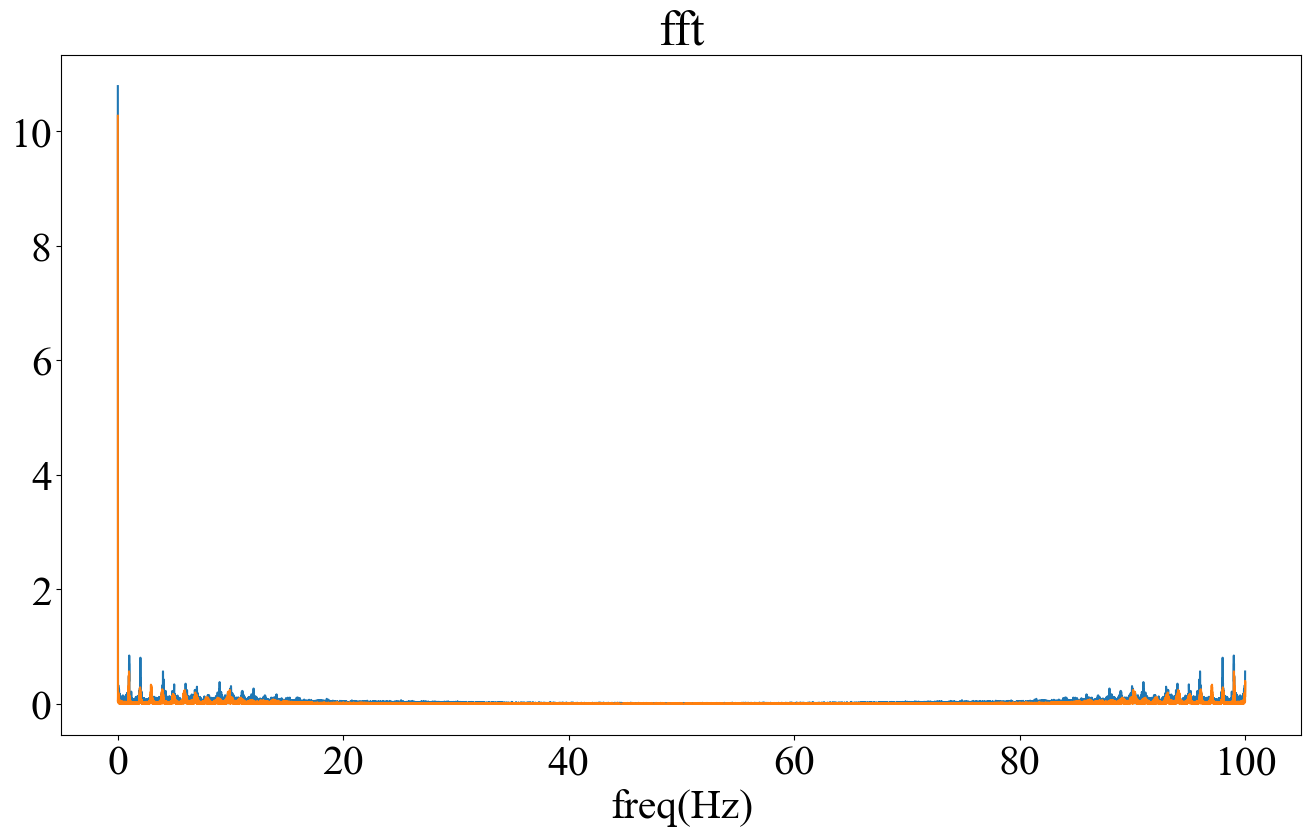

In [15]:
plt.figure(figsize=(16, 9), dpi=100)
getRawFttFigure(rjyData)
getRawFttFigure(ljmData)
plt.xlabel('freq(Hz)')
plt.title("fft")
plt.show()

### 原始数据极大值点指标计算后直方图观测数据分布

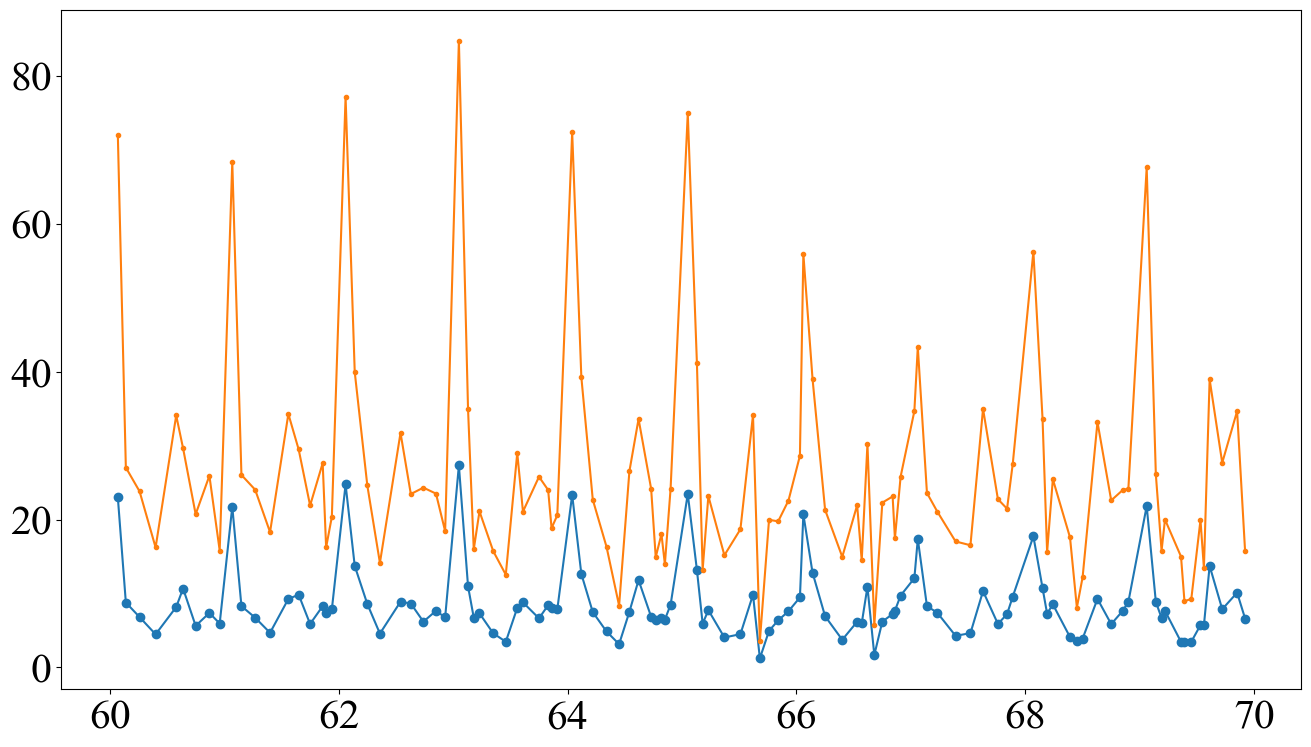

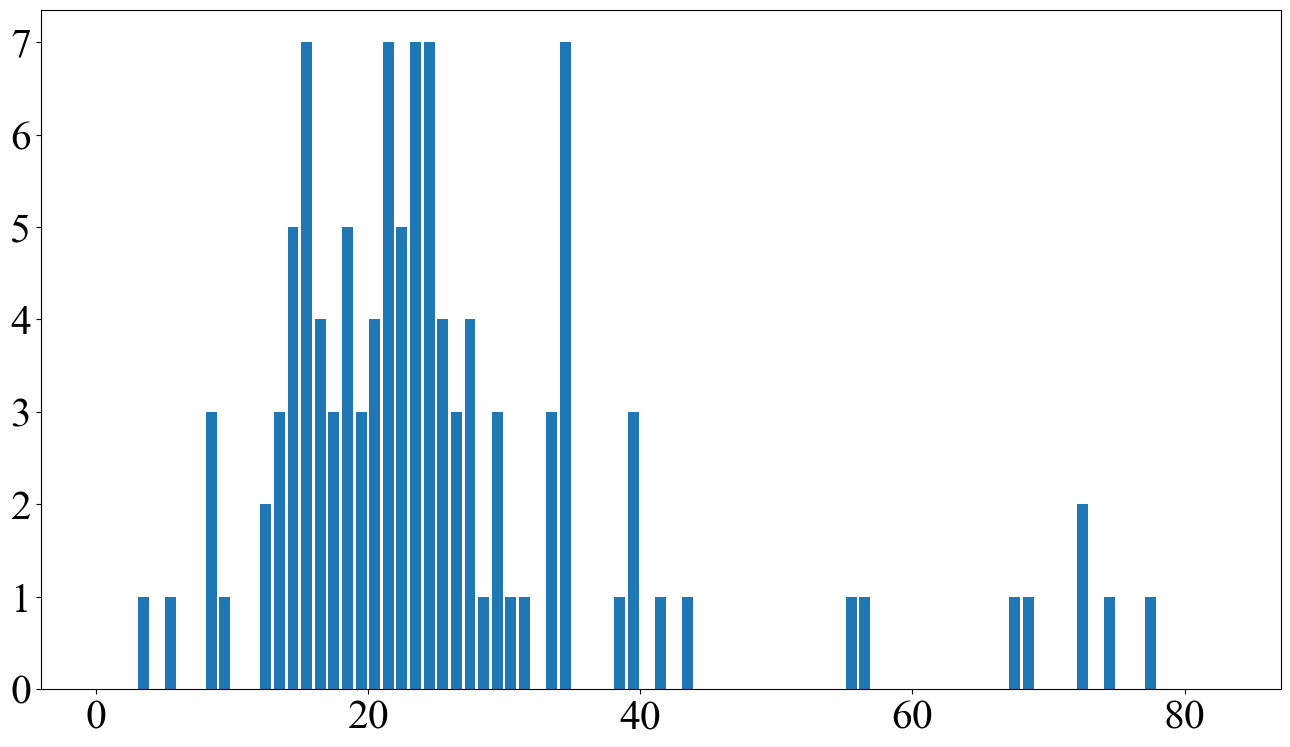

[43.34142790107727, 55.95156306006966, 56.26789317549897, 67.6479529376526, 68.37624069995204, 72.03341869577709, 72.40255851809479, 74.96904437198054, 77.19673217955469, 84.7937692775119]


In [16]:
windowSt = 60
windowSize = 10
indiList = getPeakIndicator(getAllPeakInfo(
    rjyData, "isExtre"), windowSt, windowSt+windowSize)
getHistofList(indiList)
indiList.sort()
print(indiList[-windowSize:])

### 切分并生成向量

In [17]:
rjyRawStep = splitSteps(rjyData, False)
rjyStepLenList = [len(i) for i in rjyRawStep]
ljmRawStep = splitSteps(ljmData, False)
ljmStepLenList = [len(i) for i in ljmRawStep]
allStepLenList = rjyStepLenList+ljmStepLenList
allStepLenList.sort()
targetLength = allStepLenList[int(len(allStepLenList)/2)]
targetVectorLength = int(targetLength*1.1)+1
print(targetLength)
print(targetVectorLength)


rjyStepDataList = []
for rawStep in rjyRawStep:
    processedStep = rawStep.copy()
    if len(rawStep) > targetLength*0.9 and len(rawStep) <= targetVectorLength:
        for i in range(len(rawStep), targetVectorLength):
            processedStep.append(-1)
        rjyStepDataList.append(processedStep)
print(len(rjyStepDataList))

ljmStepDataList = []
for rawStep in ljmRawStep:
    processedStep = rawStep.copy()
    if len(rawStep) > targetLength*0.9 and len(rawStep) < targetLength*1.1:
        for i in range(len(rawStep), targetVectorLength):
            processedStep.append(-1)
        ljmStepDataList.append(processedStep)
print(len(ljmStepDataList))

102
113
85
429


### 加入支撑向量机进行分类

In [18]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time

X = np.vstack((rjyStepDataList, ljmStepDataList))  # .astype(np.float64)
y = np.hstack((np.ones(len(rjyStepDataList)), np.zeros(len(ljmStepDataList))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
print(X.shape)

svc = LinearSVC(max_iter=4000)
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), ' Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

t = time.time()
n_predict = 10
print('My SVC predicts:', svc.predict(X_test[:n_predict]))
print('For these ', n_predict, ' labels:', y_test[:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict, 'labels with SVC')

Feature vector length: 113
(514, 113)
0.02  Seconds to train SVC...
Test Accuracy of SVC =  0.9871
My SVC predicts: [0. 0. 0. 1. 0. 1. 1. 0. 0. 0.]
For these  10  labels: [0. 0. 0. 1. 0. 1. 1. 0. 0. 0.]
0.002 Seconds to predict 10 labels with SVC
